In [1]:
import os 
import cv2
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support

# Set The Hyperparameter

In [2]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

# Split The Dataset

In [3]:
DATA_DIR = '../input/workoutexercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


# Data Augmentation

In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.1)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

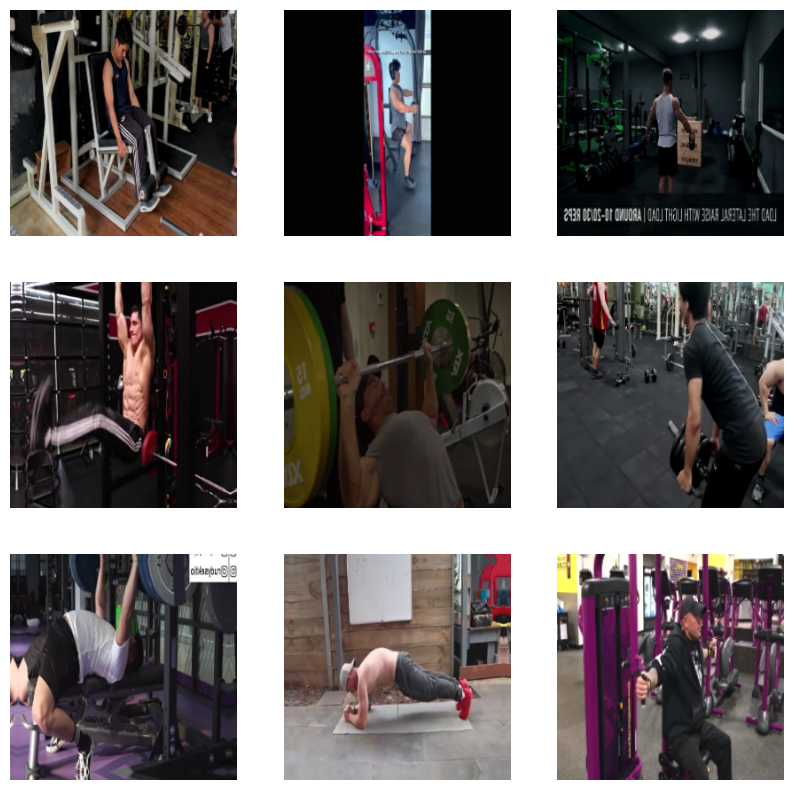

In [5]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Load Pre-Trained Model

In [6]:
# load pre-trained InceptionV3
pre_trained = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=img_shape, 
    pooling='avg'
)

for layer in pre_trained.layers:
    layer.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [7]:
x = pre_trained.output

predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Train The Model With Dataset

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'auto', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks=[early_stopping_callback]
                           )

Epoch 1/100
98/98 [==============================] - 193s 2s/step - loss: 3.5173 - accuracy: 0.2565 - val_loss: 2.1572 - val_accuracy: 0.4505
Epoch 2/100
98/98 [==============================] - 159s 2s/step - loss: 1.5381 - accuracy: 0.5848 - val_loss: 1.5020 - val_accuracy: 0.5877
Epoch 3/100
98/98 [==============================] - 155s 2s/step - loss: 1.1314 - accuracy: 0.6997 - val_loss: 1.1840 - val_accuracy: 0.6823
Epoch 4/100
98/98 [==============================] - 153s 2s/step - loss: 0.9015 - accuracy: 0.7719 - val_loss: 1.0788 - val_accuracy: 0.7271
Epoch 5/100
98/98 [==============================] - 153s 2s/step - loss: 0.7648 - accuracy: 0.8116 - val_loss: 0.9547 - val_accuracy: 0.7552
Epoch 6/100
98/98 [==============================] - 153s 2s/step - loss: 0.6575 - accuracy: 0.8440 - val_loss: 0.8595 - val_accuracy: 0.7740
Epoch 7/100
98/98 [==============================] - 151s 2s/step - loss: 0.5914 - accuracy: 0.8595 - val_loss: 0.8791 - val_accuracy: 0.7682
Epoch 

# Model Evaluation

11/11 [==============================] - 6s 268ms/step - loss: 0.5125 - accuracy: 0.8751


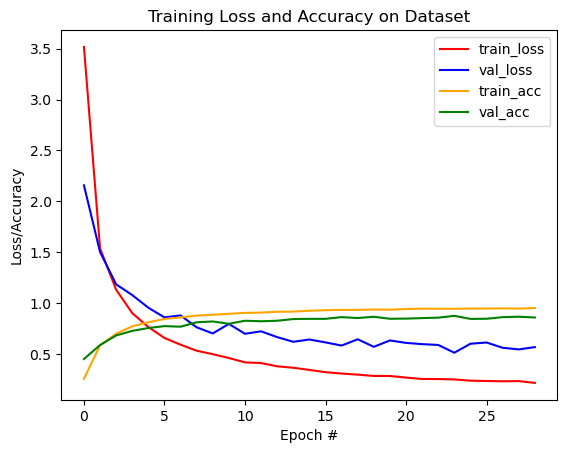

In [9]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Save The Model History

In [10]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'Xception_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save The Model

In [11]:
current_datetime = datetime.now()

# Save Model
workout_model.save(f'workout_model_{current_datetime}')

# Save .h5 model
workout_model.save(f'workout_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./workout_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'workout_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

# Testing Model

In [12]:
interpreter = tf.lite.Interpreter(model_path = f'/kaggle/working/workout_model_{current_datetime}.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 22]
type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
random_classes_names = random.choice(os.listdir('/kaggle/input/workoutfitness-video'))
random_file = random.choice(os.listdir(f'/kaggle/input/workoutfitness-video/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}\n')

# Construct the input video file path
input_video_file_path = f'/kaggle/input/workoutfitness-video/{random_classes_names}/{random_file}'

# import label from txt file
labels = []
with open('/kaggle/working/workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)
        

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (256, 256)

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

scan_count = 0
# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 10
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 15
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 30
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'
#     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*"XVID")
#         writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
#     writer.write(output)
    
#     plt.imshow(output)
#     plt.axis('off')
    
    print(f'{n}, {text}\t{results[i]}')
    scan_count += 1
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'\nActual video: {random_file}')
print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')
print(f'Scan speed: {(end_time - start_time)/scan_count} per frame\n')

# writer.release()
# video_capture.release()

result_df = pd.DataFrame({'exercise': labels,
                          'percentage': results
                         })

result_df['exercise'] = result_df['exercise'].str.strip()
result_df = result_df.sort_values('percentage', ascending=False)
result_df = result_df.reset_index(drop=True)

result_df

chest fly machine/chest fly machine_15.mp4

Duration: 4.938266666666666
FPS: 29.97002997002997
Total frame: 148.0

Prediction process
1, chest fly machine
	0.9702515006065369
11, chest fly machine
	0.6400918364524841
21, chest fly machine
	0.6097345352172852
31, chest fly machine
	0.5245332717895508
41, chest fly machine
	0.4846675992012024
51, chest fly machine
	0.5316967368125916
61, chest fly machine
	0.5389341115951538
71, chest fly machine
	0.5515480637550354
81, chest fly machine
	0.5500968098640442
91, chest fly machine
	0.5254642367362976
101, chest fly machine
	0.5000364184379578
111, chest fly machine
	0.540473461151123
121, chest fly machine
	0.5104130506515503
131, chest fly machine
	0.47780904173851013
141, chest fly machine
	0.4684191942214966

Actual video: chest fly machine_15.mp4
Prediction: chest fly machine

confidence: 0.4684191942214966
Prediction time: 2.505192518234253 sec
Scan speed: 0.1670128345489502 per frame



,exercise,percentage
0,chest fly machine,0.468419
1,tricep dips,0.173269
2,pull up,0.073156
3,barbell biceps curl,0.066506
4,lat pulldown,0.045870
5,t bar row,0.037314
6,plank,0.023435
7,tricep pushdown,0.015473
8,leg raises,0.014237
9,shoulder press,0.012860
